<a href="https://colab.research.google.com/github/Xavierree/NLP_RACE/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek UAS NLP: Topic Modelling pada RACE Dataset (Optimized)

**Nama:** Eideltha Xavierre Sembiring Kembaren
**NIM:** 36230034
**Kelas:** 5PDS1

Proyek ini bertujuan untuk melakukan *Topic Modelling* pada RACE Dataset. Kode ini telah dioptimasi dengan teknik tingkat lanjut:
1.  **N-Grams (Bigrams):** Menggabungkan kata (misal: *high_school*) untuk konteks yang lebih jelas.
2.  **Strict Filtering:** Menghapus kata yang terlalu umum/jarang.
3.  **Auto-Tuning (Alpha/Eta):** Membiarkan model LDA mempelajari distribusi prior secara otomatis.

## 1. Setup, Instalasi, dan Import Library

Instalasi library dan import modul yang diperlukan.

In [ ]:
# Instalasi Library (Hapus tanda # jika di Colab)
!pip install tensorflow_datasets gensim wordcloud pyldavis bertopic[gpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.0 MB/s eta 0:00:00


In [ ]:
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import re
import string
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP & Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Sklearn (LSA, NMF, Vectorization)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

# Gensim (LDA & Evaluation)
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, Phraser # Untuk N-Grams

# Visualisasi Interaktif
import pyLDAvis
import pyLDAvis.gensim_models as gensim_pyldavis

# BERTopic
from bertopic import BERTopic

# Filter Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Download Resources NLTK
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Setup Selesai. Ready to go!")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use

Setup Selesai. Ready to go!


## 2. Pemuatan Dataset (RACE)

Mengambil data `train` dari dataset RACE (Reading Comprehension).

In [ ]:
print("--- Memuat Dataset RACE ---")
ds = tfds.load('race', split='train', shuffle_files=True)

passages = []
for example in ds:
    passages.append(example['article'].numpy().decode('utf-8'))

df = pd.DataFrame({'text': passages})
print(f"Total dokumen: {len(df)}")
print("Contoh data:", df['text'].iloc[0][:100], "...")

--- Memuat Dataset RACE ---


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/race/high/incomplete.3XFTYR_2.0.0/race-train.tfrecord*...:   0%|          …

Generating dev examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/race/high/incomplete.3XFTYR_2.0.0/race-dev.tfrecord*...:   0%|          | …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/race/high/incomplete.3XFTYR_2.0.0/race-test.tfrecord*...:   0%|          |…

Dataset race downloaded and prepared to /root/tensorflow_datasets/race/high/2.0.0. Subsequent calls will reuse this data.
Total dokumen: 18728
Contoh data: Answering the Community Needs of Our City
The Silver City Council  recognizes that citizens have cer ...


## 3. Preprocessing Lanjutan (Termasuk N-Grams)

Di sini kita menerapkan **Teknik N-Grams (Bigrams)** agar kata seperti "New York" atau "High School" dianggap sebagai satu kesatuan (token), bukan dua kata terpisah. Ini sangat meningkatkan koherensi topik.

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def basic_clean(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

def tokenize_and_filter(text):
    tokens = word_tokenize(text)
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

print("1. Basic Cleaning & Tokenization...")
df['clean_text'] = df['text'].apply(basic_clean)
data_tokens = df['clean_text'].apply(tokenize_and_filter).tolist()

# --- TEKNIK OPTIMASI: N-GRAMS (Bigrams) ---
print("2. Membuat Bigrams (Contoh: 'high' + 'school' -> 'high_school')...")
# min_count=5: hiraukan kata yang muncul kurang dari 5 kali
# threshold=10: semakin tinggi, semakin sedikit bigram yang terbentuk (hanya yang sangat sering bersama)
bigram = Phrases(data_tokens, min_count=5, threshold=10)
bigram_mod = Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Terapkan Bigrams
data_tokens_bigrams = make_bigrams(data_tokens)

# Simpan hasil akhir ke DF untuk dipakai LSA/BERTopic nanti
df['processed_tokens'] = data_tokens_bigrams
df['processed_text_joined'] = df['processed_tokens'].apply(lambda x: " ".join(x))

print("Preprocessing & N-Grams Selesai.")
print("Contoh Token Bigram:", df['processed_tokens'].iloc[0][:10])

1. Basic Cleaning & Tokenization...
2. Membuat Bigrams (Contoh: 'high' + 'school' -> 'high_school')...
Preprocessing & N-Grams Selesai.
Contoh Token Bigram: ['answering', 'community', 'need', 'city', 'silver', 'city_council', 'recognizes', 'citizen', 'certain', 'need']


### Visualisasi Word Cloud
Melihat kata dominan setelah dibersihkan dan digabung (bigram).

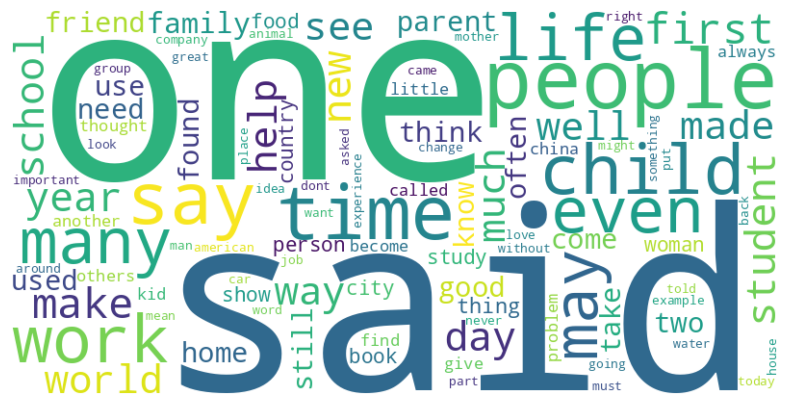

In [ ]:
long_string = " ".join(df['processed_text_joined'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(long_string)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4. Vectorization (TF-IDF & BoW)

Di sini kita menerapkan **Filter Extremes** yang ketat untuk membuang kata-kata yang terlalu pasaran (muncul di >50% dokumen) atau terlalu langka.

In [ ]:
# A. TF-IDF (untuk LSA/NMF)
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=20, max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text_joined'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"TF-IDF Matrix: {tfidf_matrix.shape}")

# B. Bag-of-Words (untuk LDA)
# Buat Dictionary
id2word = corpora.Dictionary(df['processed_tokens'])
print(f"Jumlah kata unik sebelum filter: {len(id2word)}")

# --- TEKNIK OPTIMASI: FILTER EXTREMES KETAT ---
# Hapus kata yang muncul di kurang dari 20 dokumen (terlalu unik/typo)
# Hapus kata yang muncul di lebih dari 50% dokumen (terlalu umum, mirip stopwords)
id2word.filter_extremes(no_below=20, no_above=0.5)
print(f"Jumlah kata unik setelah filter: {len(id2word)}")

corpus = [id2word.doc2bow(text) for text in df['processed_tokens']]

TF-IDF Matrix: (18728, 2000)
Jumlah kata unik sebelum filter: 124823
Jumlah kata unik setelah filter: 10079


## 5. Modelling

Fungsi visualisasi untuk semua model.

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title, model_type='sklearn'):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_ if model_type=='sklearn' else range(model.num_topics)):
        if model_type == 'sklearn':
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
        else:
            topic_terms = model.show_topic(topic_idx, n_top_words)
            top_features = [t[0] for t in topic_terms]
            weights = [t[1] for t in topic_terms]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle(title, fontsize=40)
    plt.show()

N_TOPICS = 10

### LSA & NMF (Baseline)

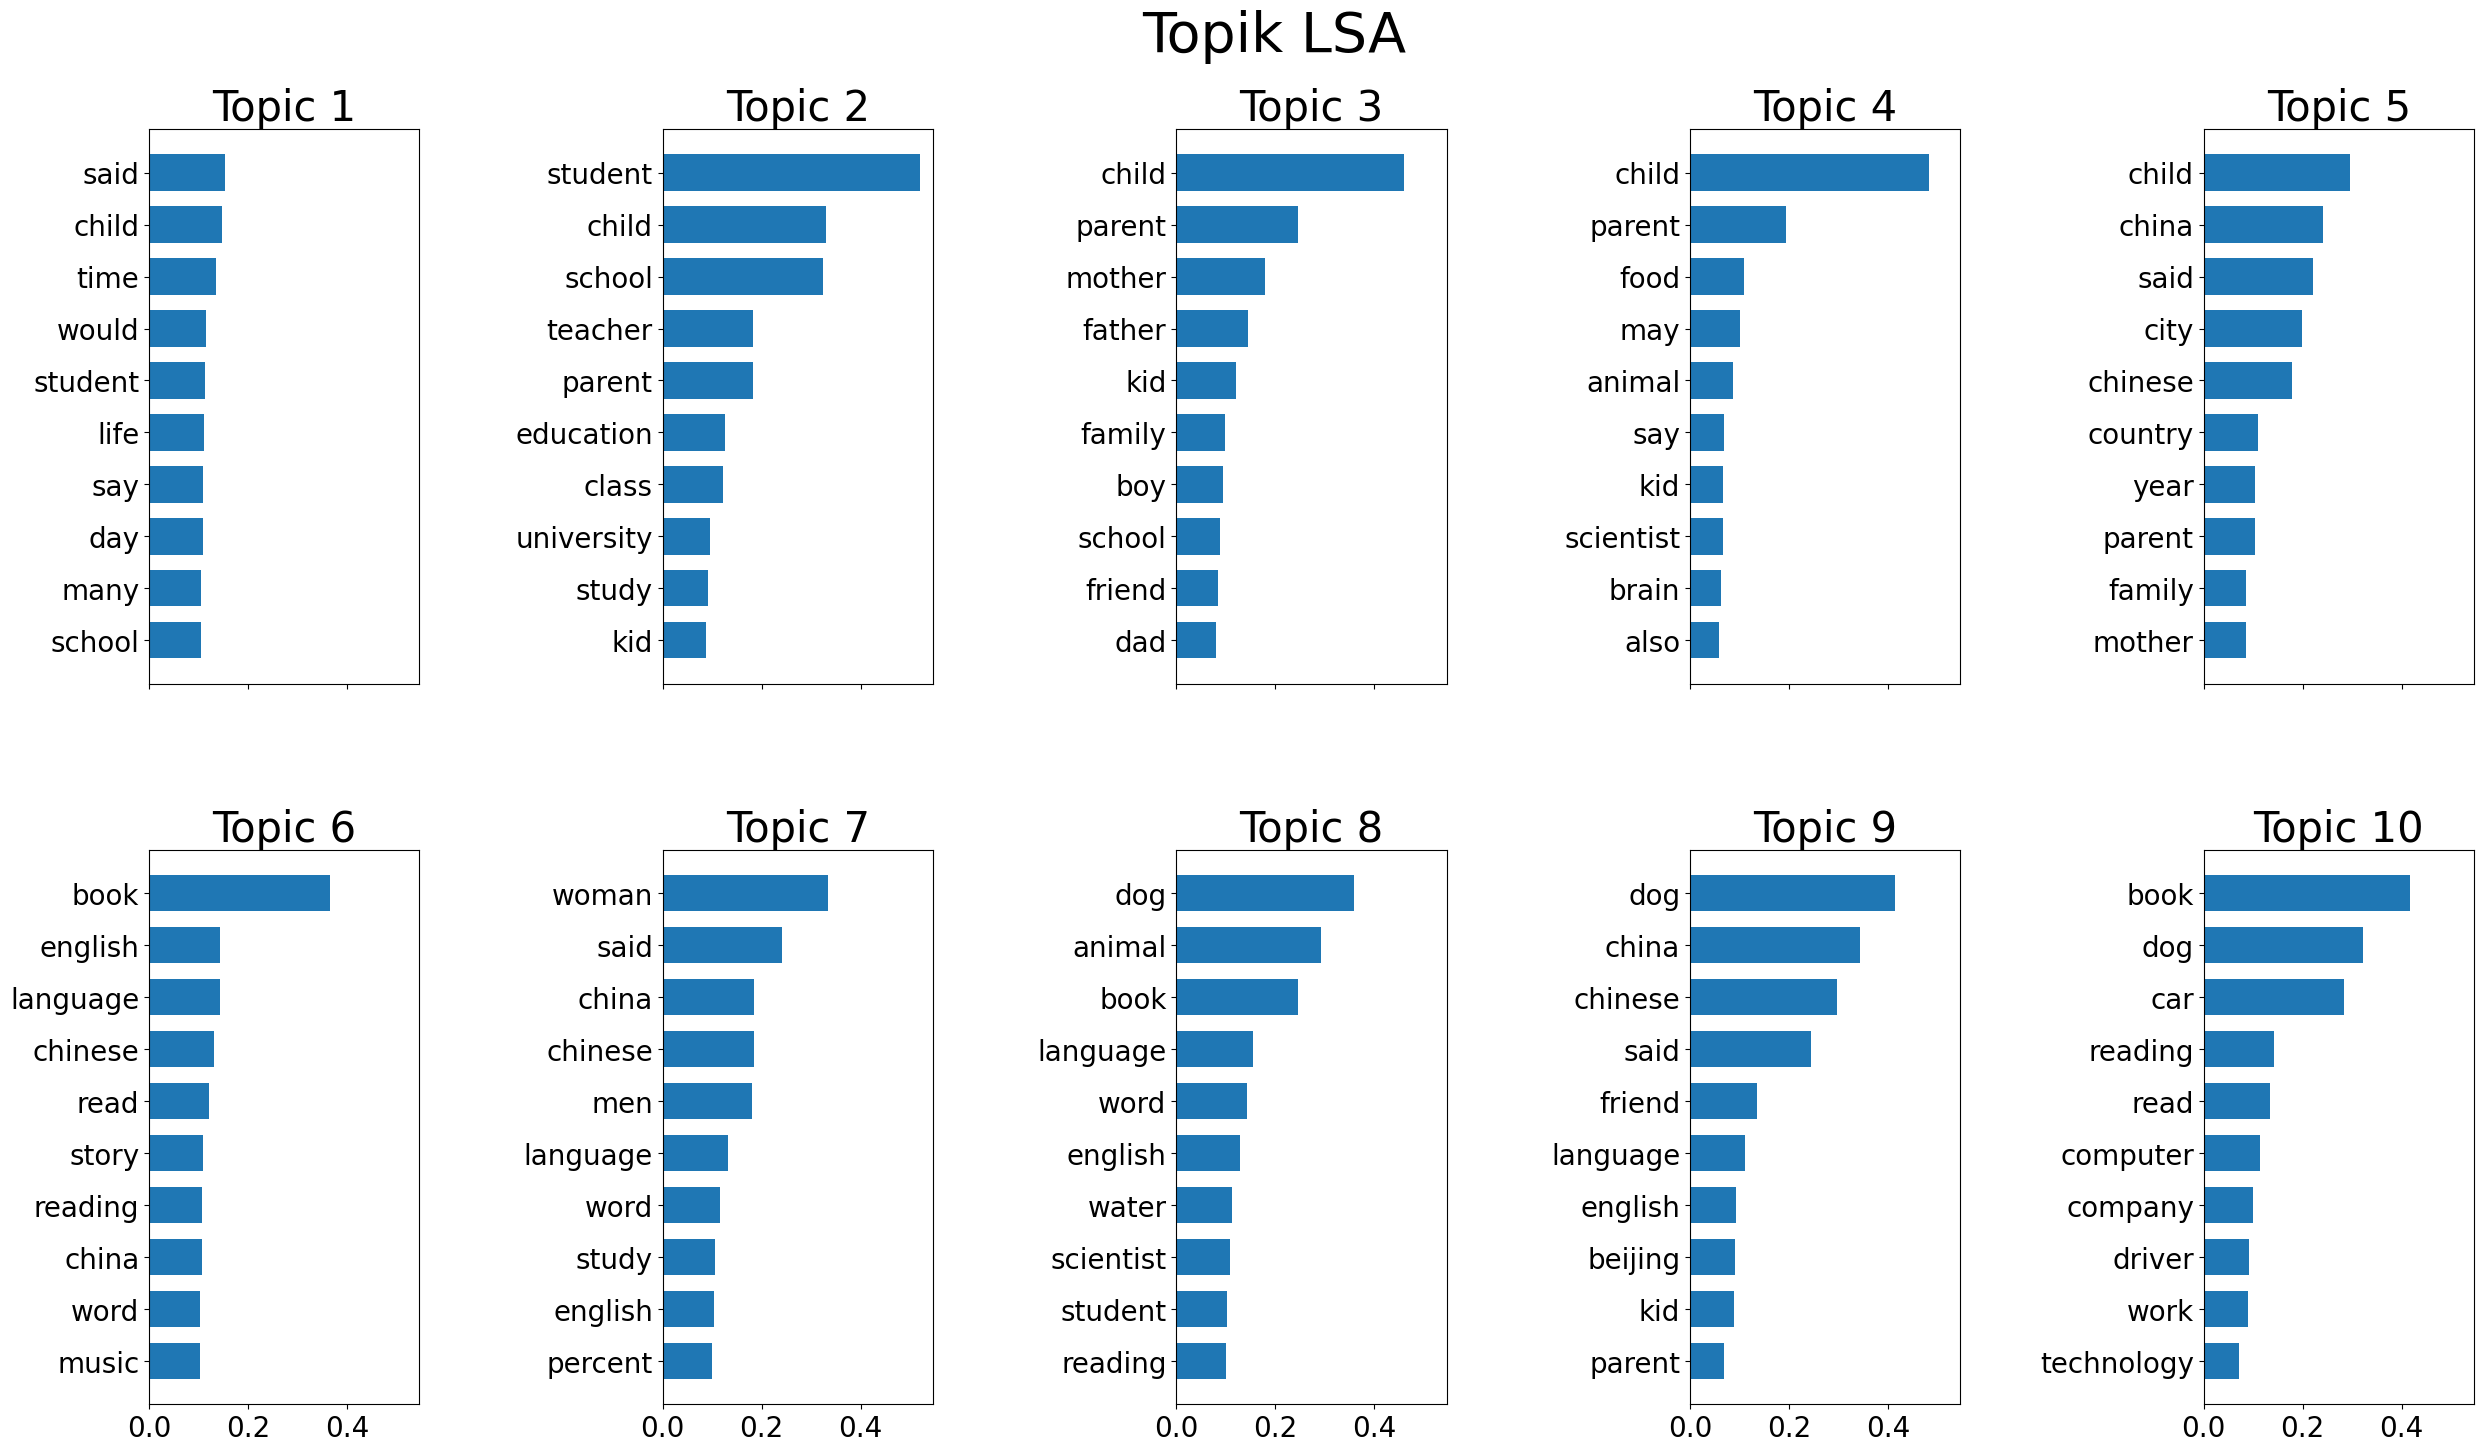

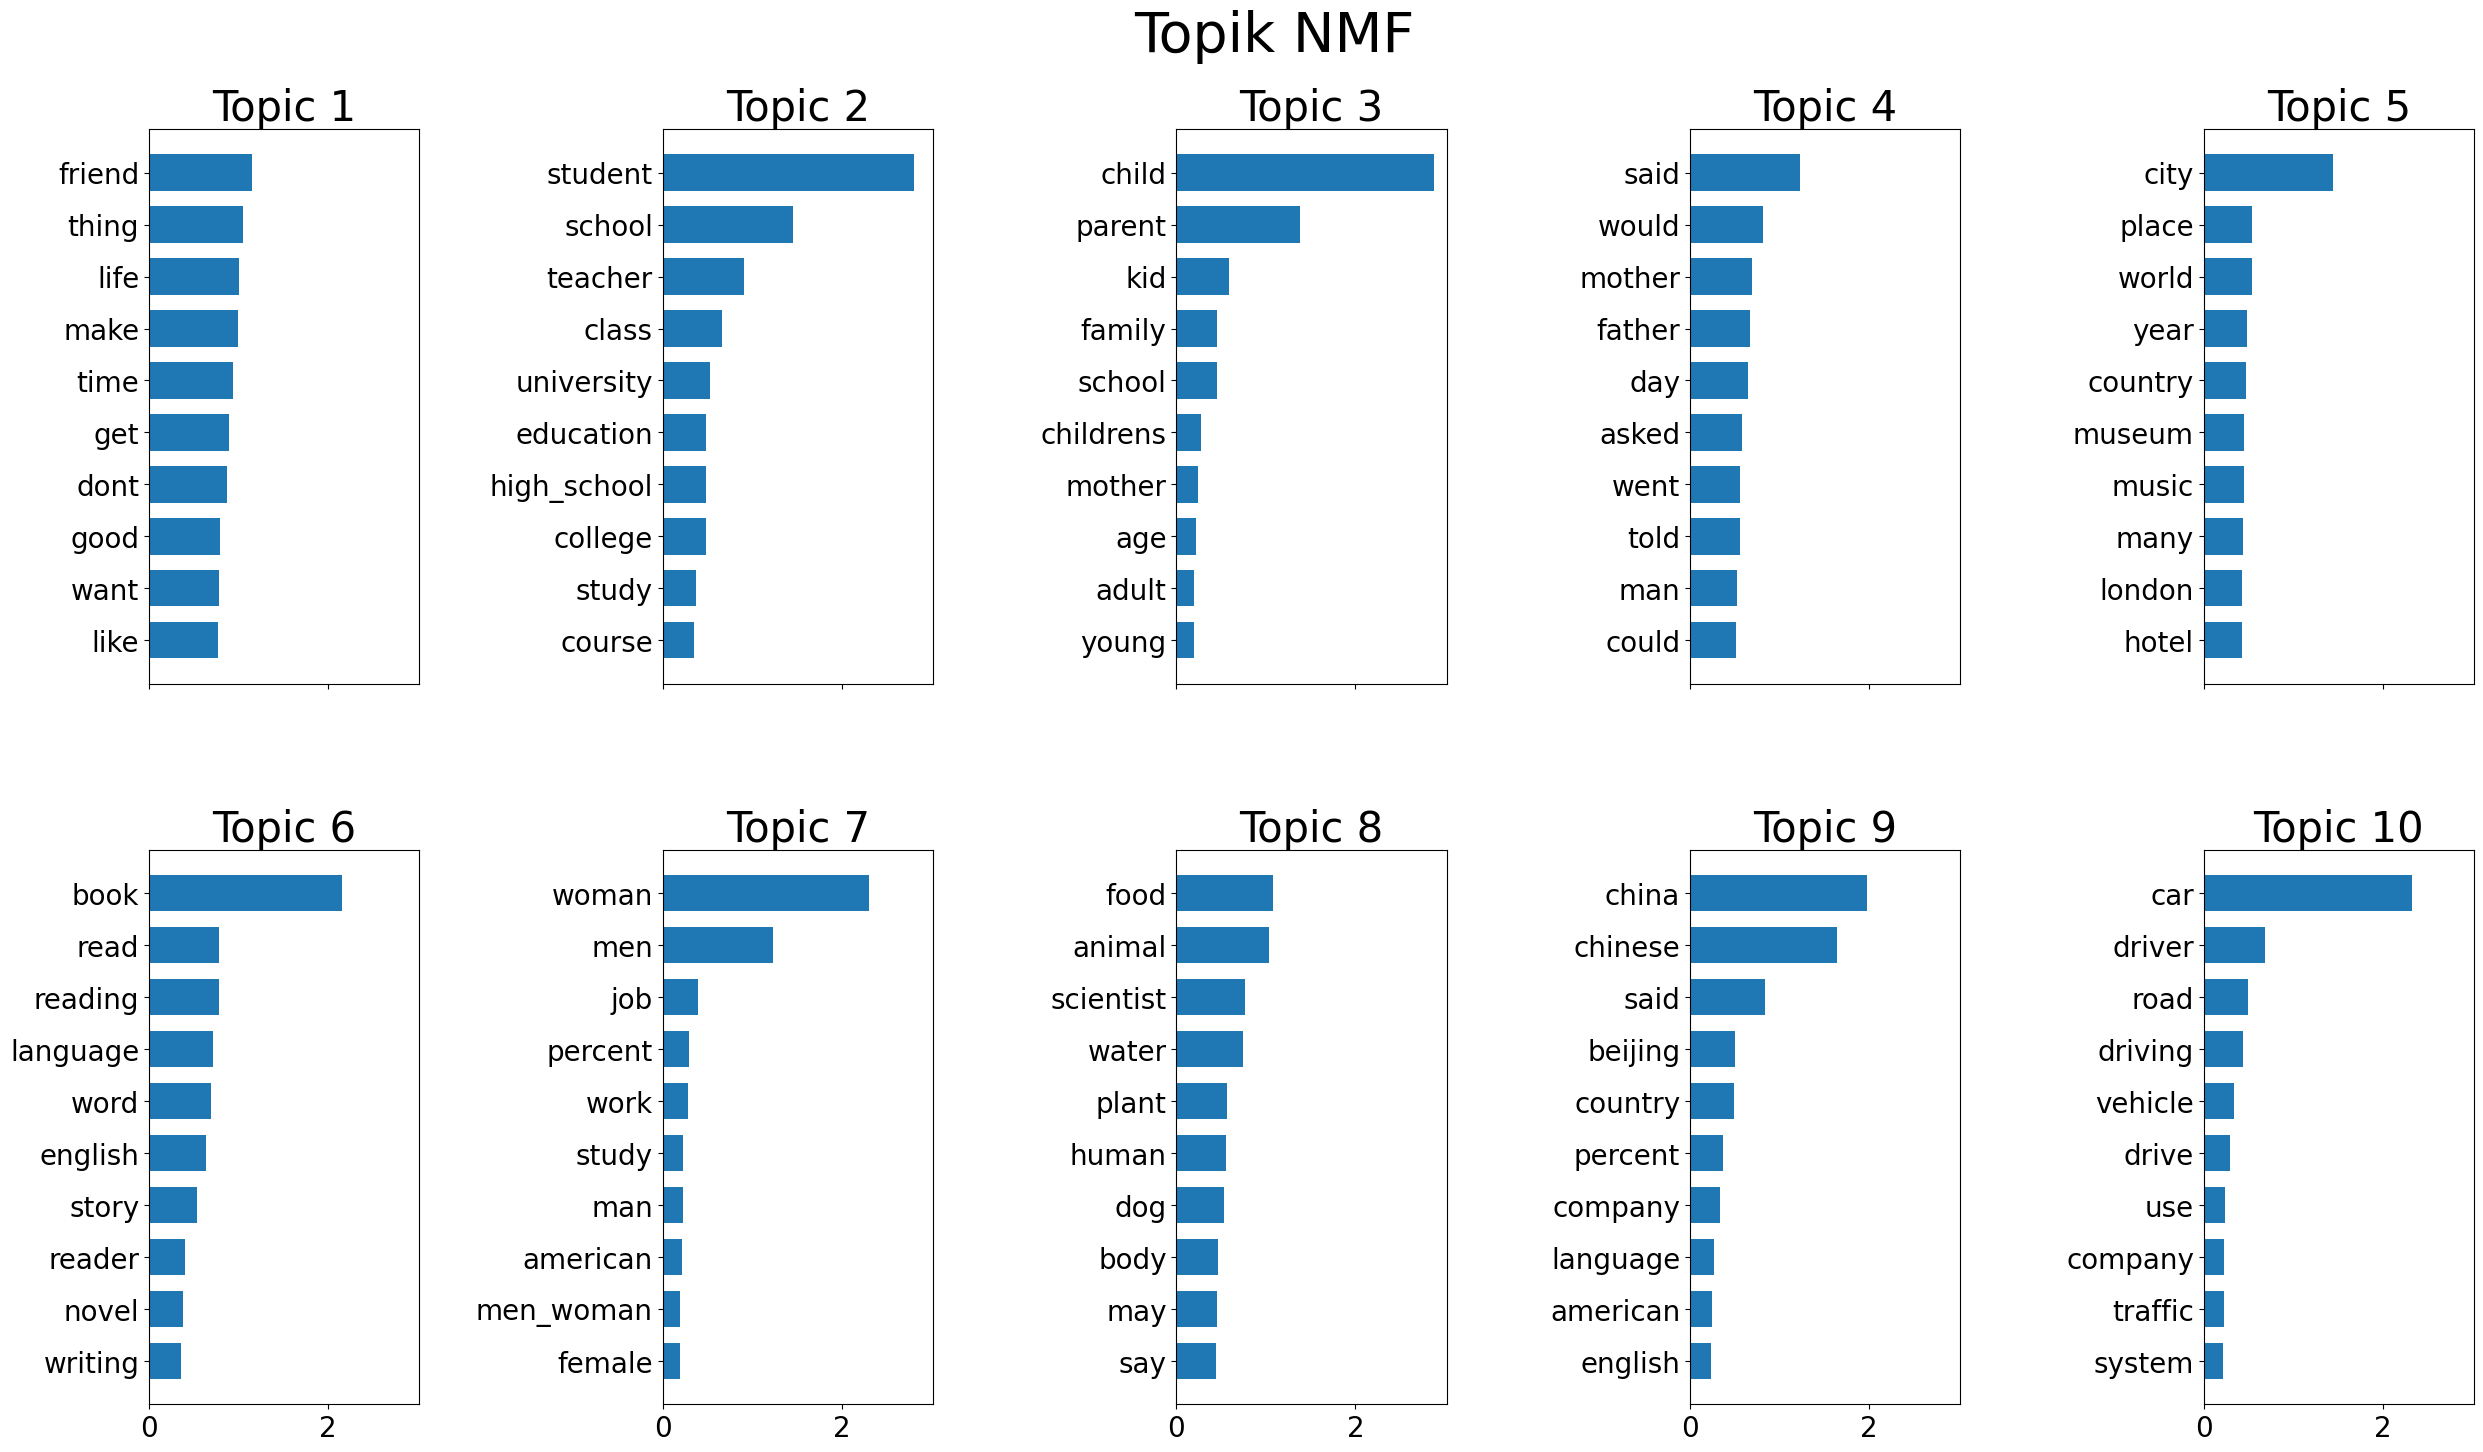

In [ ]:
# LSA
lsa_model = TruncatedSVD(n_components=N_TOPICS, random_state=42)
lsa_model.fit(tfidf_matrix)
plot_top_words(lsa_model, tfidf_feature_names, 10, 'Topik LSA', 'sklearn')

# NMF
nmf_model = NMF(n_components=N_TOPICS, random_state=42, init='nndsvda')
nmf_model.fit(tfidf_matrix)
plot_top_words(nmf_model, tfidf_feature_names, 10, 'Topik NMF', 'sklearn')

### LDA Optimized (Auto-Tuning)

Di sini kita menerapkan **Tuning Alpha & Eta = 'auto'**.
*Note:* Untuk pencarian jumlah topik (Step 1), kita tetap pakai `LdaMulticore` (cepat) dengan default. Tapi untuk model final (Step 2), kita pakai `LdaModel` (single core) agar bisa mengaktifkan fitur `auto` alpha/eta.

Mulai Tuning Cepat...


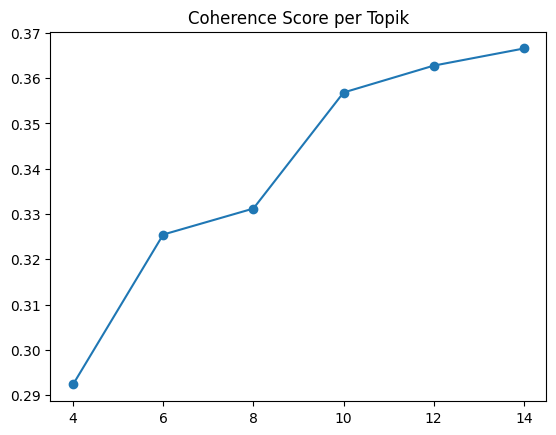


Melatih LDA Final dengan 14 Topik menggunakan Alpha='auto' & Eta='auto'...

--- Evaluasi LDA Final ---
Log Perplexity: -7.8538
Coherence Score (C_v): 0.4425


IndexError: index 10 is out of bounds for axis 0 with size 10

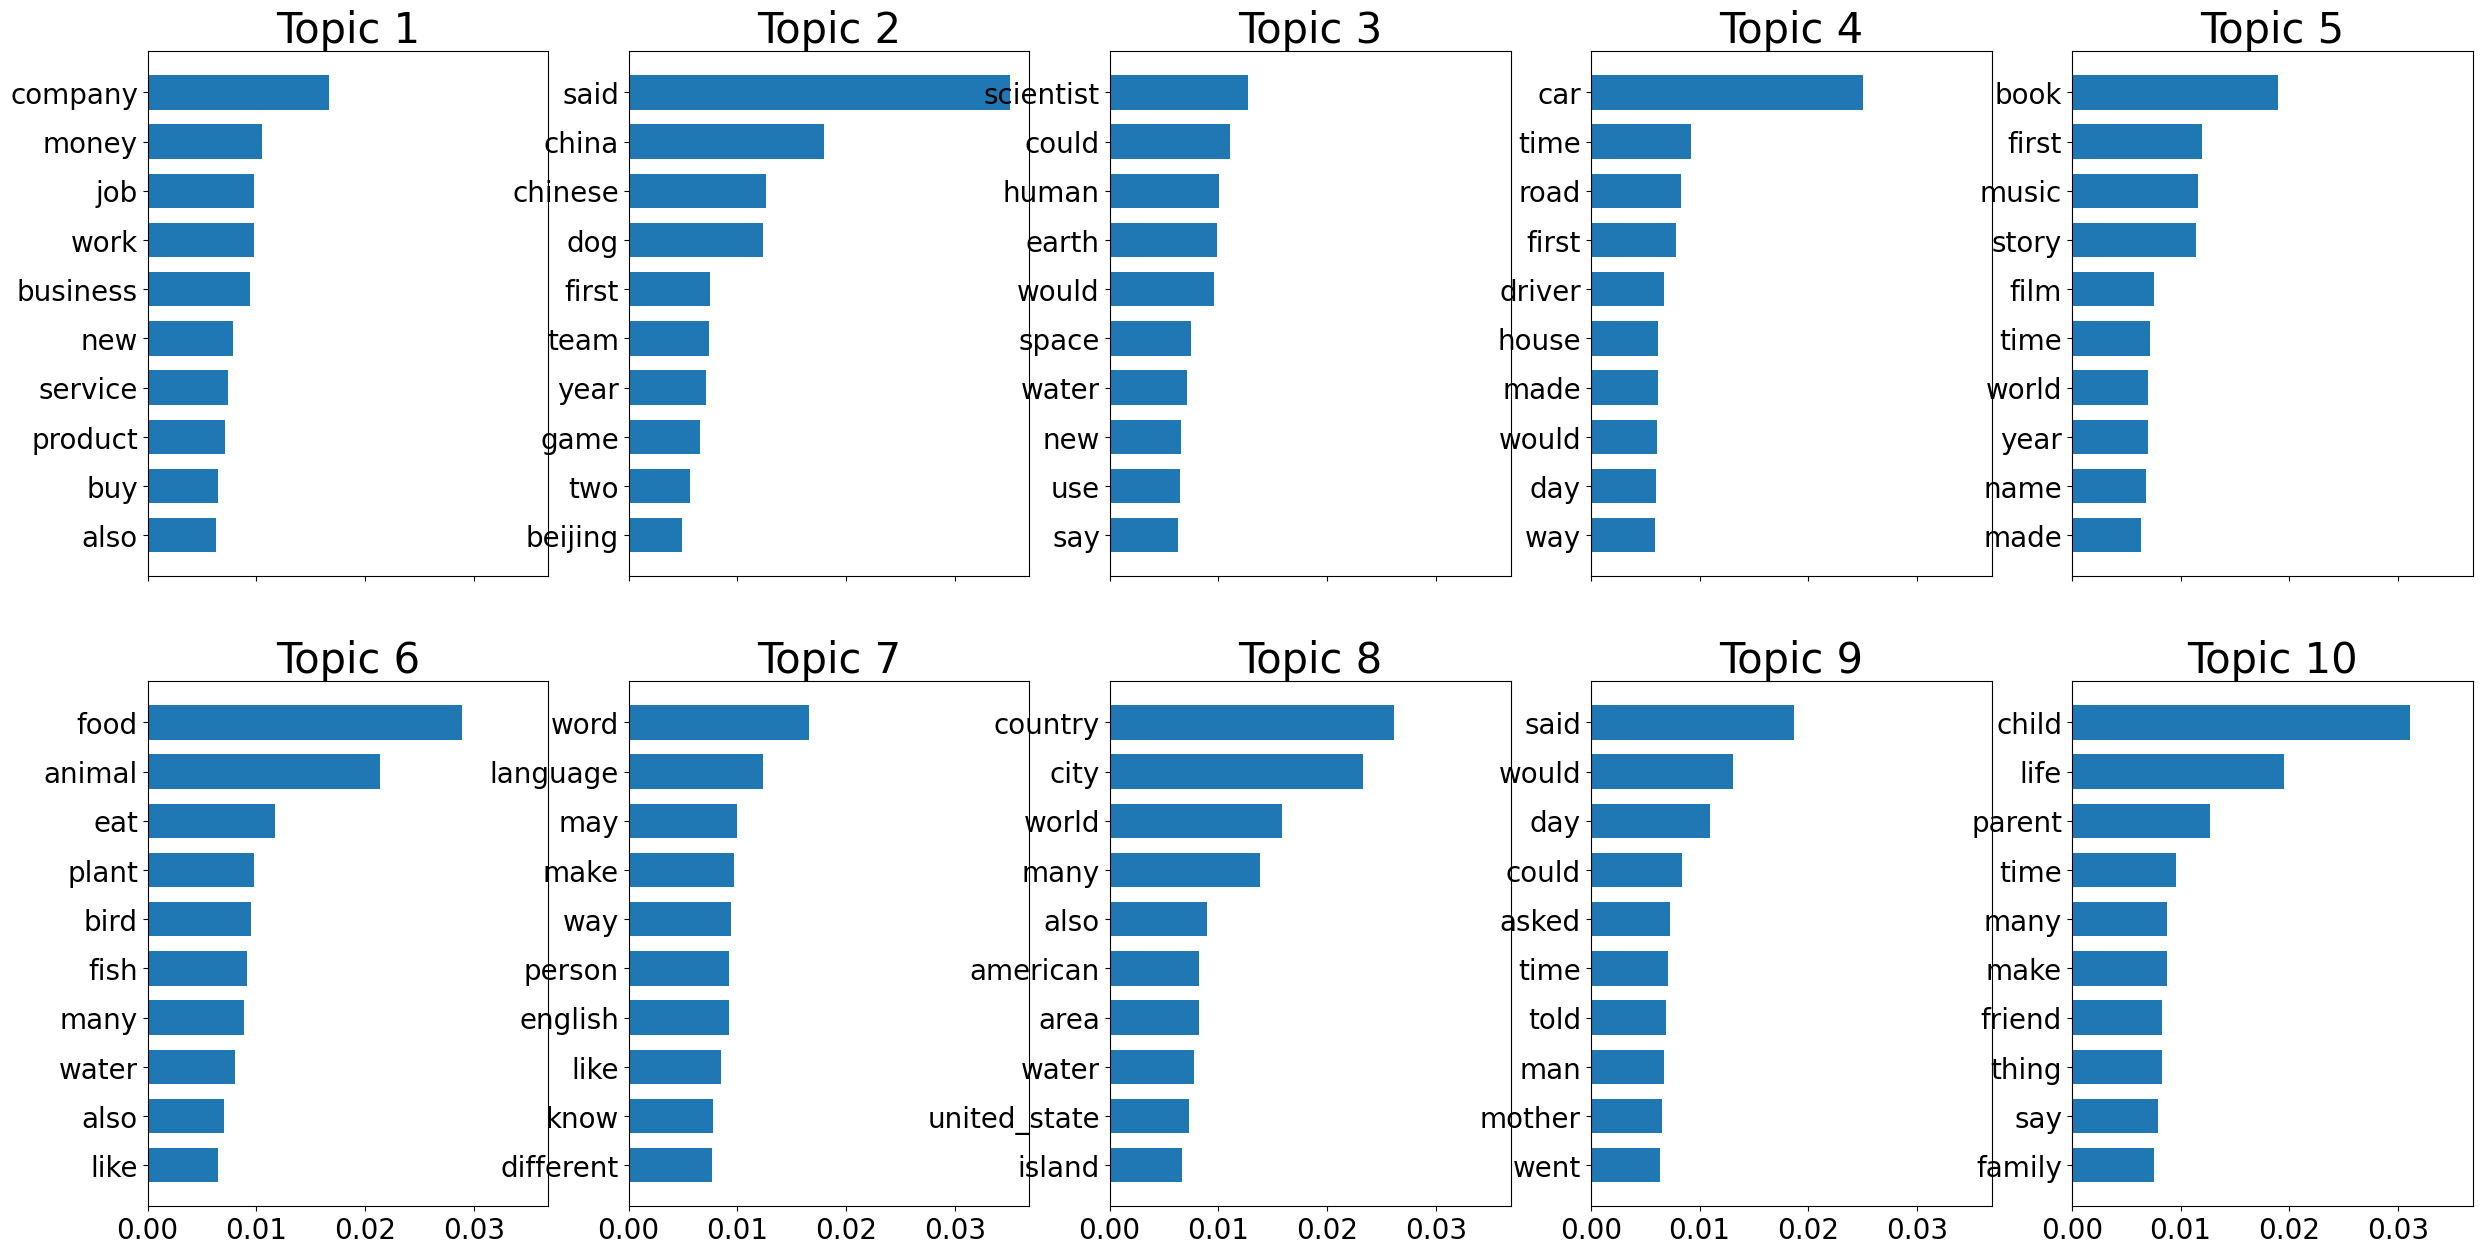

In [ ]:
# STEP 1: Tuning Cepat untuk mencari N Topik (pakai Multicore)
def compute_coherence_fast(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    print("Mulai Tuning Cepat...")
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                             random_state=42, passes=2, workers=None)
        cm = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())
    return coherence_values

limit=16; start=4; step=2
coherence_vals = compute_coherence_fast(id2word, corpus, df['processed_tokens'], limit, start, step)

# Plot
x = range(start, limit, step)
plt.plot(x, coherence_vals, marker='o')
plt.title("Coherence Score per Topik")
plt.show()

# STEP 2: Final Training (Optimized dengan 'auto')
optimal_n = x[np.argmax(coherence_vals)]
print(f"\nMelatih LDA Final dengan {optimal_n} Topik menggunakan Alpha='auto' & Eta='auto'...")

# --- TEKNIK OPTIMASI: AUTO ALPHA & ETA ---
# LdaModel (bukan Multicore) mendukung auto-learning untuk prior distribution
lda_final = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=optimal_n,
                     random_state=42,
                     passes=10,
                     alpha='auto',  # Model belajar densitas dokumen-topik
                     eta='auto')    # Model belajar densitas topik-kata

# Evaluasi Akhir
print("\n--- Evaluasi LDA Final ---")
print(f"Log Perplexity: {lda_final.log_perplexity(corpus):.4f}")
cm_final = CoherenceModel(model=lda_final, texts=df['processed_tokens'], dictionary=id2word, coherence='c_v')
print(f"Coherence Score (C_v): {cm_final.get_coherence():.4f}")

plot_top_words(lda_final, None, 10, f'Topik LDA Final ({optimal_n})', 'gensim')

## 6. Visualisasi Interaktif (pyLDAvis)

Visualisasi ini menunjukkan hasil LDA Final yang sudah dioptimasi.

In [ ]:
pyLDAvis.enable_notebook()
try:
    vis_data = gensim_pyldavis.prepare(lda_final, corpus, id2word, mds='tsne')
    vis_data
except Exception as e:
    print(f"Gagal pyLDAvis: {e}")

## 7. Model 4: BERTopic

Model berbasis Transformer yang memanfaatkan embedding.

In [ ]:
try:
    print("Training BERTopic...")
    # Gunakan sample 5000 jika tanpa GPU
    docs_bert = df['processed_text_joined'].sample(5000, random_state=42).tolist()

    topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", verbose=True)
    topics, probs = topic_model.fit_transform(docs_bert)

    print(topic_model.get_topic_info().head(10))
    topic_model.visualize_barchart(top_n_topics=10).show()
except Exception as e:
    print(f"BERTopic Error: {e}")

## 8. Kesimpulan

Penerapan teknik optimasi (Bigrams, Filtering, Auto-Tuning) diharapkan meningkatkan koherensi topik dibandingkan model baseline. LDA kini mampu menangkap frasa seperti 'high_school' dan memiliki distribusi topik yang lebih natural.